# <center>Adios3 Evaporation Instructions</center>

## <center>Based on document updated 09-11-2015</center>

## <u>Construction of the Pseudo Components</u>

### Data Condition 1: distillation data available (crudes and refined products)

Inputs:
<ul>
<li>cumulative distilled mass</li>
<li>true boiling points</li>
</ul>

If two or more vapor temperature distillation date points are available, then this data is used to determine the properties of the pseudo-components (PC).  If distillation data is measured at a reduced pressure, it must be adjusted to atmospheric pressure.<br>
The data are stored as pairs of values:
<ul>
    <li>The temperature of the distillate $(T_i)$</li>
    <li>The cumulative fraction of oil distilled $(f_i)$</li>
</ul>

The temperature of the initial fraction is found by extrapolating the first two points:

$$
\begin{align}
f_i &= \text{the cumulative mass fraction of oil distilled} \cr
T_i &= \text{measured temperature of distillate} (K) \cr
\cr
T_0 &= T_1 - f_1 \left( T_2 - T_1 \over f_2 - f_1 \right) \cr
\end{align}
$$

The temperature of the <b>final</b> fraction is found by extrapolating the first and last distillation points.

$$
\begin{align}
T_{n + 1} &= T_n + (1 - f_1) \left( T_n - T_1 \over f_n - f_1 \right) \cr
\end{align}
$$

Or a linear least squares fit to the distillation data can be used.<br>
Five PCs, each containing 20% of the oil by mass, are constructed as follows:
<ul>
    <li>The boiling point (BP) of the first PC is the average of the lower and upper cut temperatures.  The lower temperature is the temperature of the initial fraction; upper temperature is found through a linear interpolation of the points that bracket 20% distilled.</li>
    <li>The BP of the second, third, and fourth PCs are found in a similar manner, where the lower temperature is the upper temperature of the previous PC.</li>
    <li>The BP of the fifth PC is the average of the upper temperature of the fourth PC and the temperature of the final fraction.</li>
</ul>

### <center>(JLM Comments) </center>

I think I might prefer the least squares fit approach, but let's try out the above formulas, shall we?

First, $T_0$ seems pretty straight forward, but what is the intent?  Is it to determine at what temperature we will find 0% distillation?<br>
Second, $T_{n+1}$ seems to me to be an attempt to determine at what temperature we will find 100% distillation.<br>
Fair enough, but the equation should probably be:<br>

$$
\begin{align}
T_{n + 1} &= T_n + (1 - f_n) \left( T_n - T_1 \over f_n - f_1 \right) \cr
\end{align}
$$

In [6]:
%pylab inline
import numpy as np

# here is the cut data from AK North slope (Middle Pipeline)
boiling_points, cum_fractions = [np.array(l)
                                 for l in zip(*((313.15, 0.03),
                                                (353.15, 0.07),
                                                (393.15, 0.13),
                                                (433.15, 0.19),
                                                (473.15, 0.25),
                                                (573.15, 0.42),
                                                (673.15, 0.6),
                                                (773.15, 0.76),
                                                (873.15, 0.88),
                                                (973.15, 0.95)))]

print boiling_points, cum_fractions

t_min = boiling_points[0] - cum_fractions[0] * ((boiling_points[1] - boiling_points[0]) /
                                                (cum_fractions[1] - cum_fractions[0]))

t_max = (boiling_points[-1] +
         (1. - cum_fractions[-1]) *
         ((boiling_points[-1] - boiling_points[0]) /
          (cum_fractions[-1] - cum_fractions[0]))
         )

print '(t_min, t_max) = ', (t_min, t_max)

Populating the interactive namespace from numpy and matplotlib
[ 313.15  353.15  393.15  433.15  473.15  573.15  673.15  773.15  873.15
  973.15] [ 0.03  0.07  0.13  0.19  0.25  0.42  0.6   0.76  0.88  0.95]
(t_min, t_max) =  (283.14999999999998, 1009.0195652173913)


Ok, that's not too bad.  We might be able to work with that.<br>
But just for fun, let's try out a least squares (or some kind of) optimization.

j = 1.00000013943, k = 3.40672469007, lamb = 6.73589894114


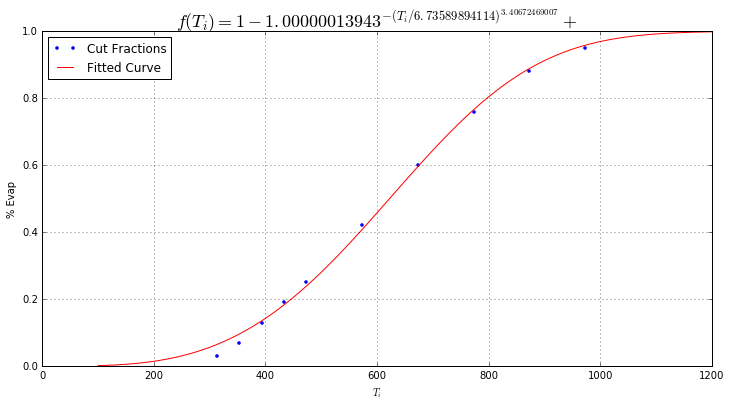

In [93]:
from scipy.optimize import curve_fit

plt.figure(1, figsize=(12,6))
plt.subplot(111)

plt.plot(boiling_points, cum_fractions, '.b', label="Cut Fractions")

plt.xlabel(r'$T_i$')
plt.ylabel('% Evap')
plt.grid()

#def func(x, a, b, c, d):
#    return a*x**3 + b*x**2 +c*x + d
def func(x, j, k, lamb):
    # intuitively, our cut fractions seem to approximate
    # a similar shape as a cumulative distribution function.
    return (1.0 - j ** (-1.0 * (x / lamb) ** k))

"""
make the curve_fit
"""
popt, pcov = curve_fit(func, boiling_points, cum_fractions)
print "j = {}, k = {}, lamb = {}".format(*popt)
plt.title(r'$f(T_i)= '
          '1 - {0}^{{-(T_i / {2})^{{{1}}} }} + '
          '$'.format(*popt),
          fontsize=18)

# now plot our curve with a bunch of boiling points from 273K to 1015K
new_bps = np.linspace(100., 1200., 100)
plt.plot(new_bps, func(new_bps, *popt), '-r', label="Fitted Curve")

plt.legend(loc='upper left')


Alright, our oil record has a reasonably large number of samples, and our function fits the data pretty closely.<br>
Of course that does not mean it will work for every oil, particularly the oils that have a sparse number of cuts.  But I think this is promising.

So if we imagine our function approximating $(1 - j^{-(x / \lambda)^k})$ resulting in a set of values in the range
$\{ 0 < f < 1 \, | \,\, f \in \Bbb R \}$, then we can also imagine an inverse function, similar to the quantile function.  This function should be able to determine the temperatures at which we approach 0% and 100% mass fractions.<br>
Here is the form this function might take:

$$
\begin{align}
T(f_i; j, k, \lambda) &= \lambda (-log_j(1 - f_i))^{1/k}
\end{align}
$$

Let's try it out...

j = 1.00000013943, k = 3.40672469007, lamb = 6.73589894114


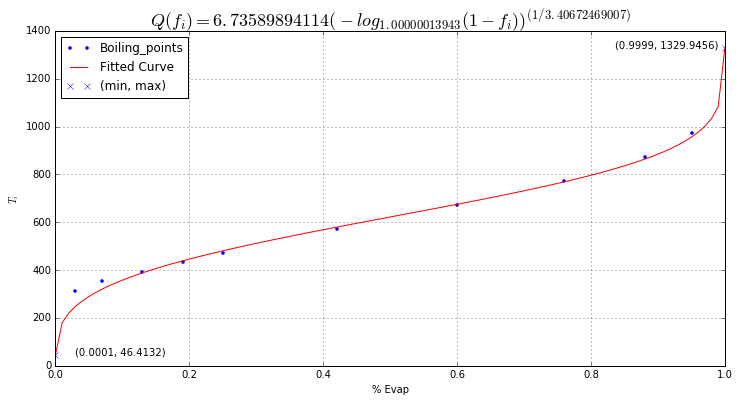

In [139]:
def func(x, j, k, lamb):
    # intuitively, our cut fractions seem to approximate
    # a similar shape as a cumulative distribution function.
    return (1.0 - j ** (-1.0 * (x / lamb) ** k))

def quant(f, j, k, lamb):
    # inverse to our cut fraction function
    # (note: numpy has no direct log_n function so we need to use the rule
    #        log_n(x) = log(x) / log(n))
    return (lamb *
            (-1.0 * (np.log(1.0 - f) / np.log(j))) ** (1.0 / k))

"""
make the curve_fit
"""
popt, pcov = curve_fit(func, boiling_points, cum_fractions)
print "j = {}, k = {}, lamb = {}".format(*popt)

plt.figure(1, figsize=(12,6))
plt.subplot(111)

plt.plot(cum_fractions, boiling_points, '.b', label="Boiling_points")

plt.xlabel('% Evap')
plt.ylabel(r'$T_i$')
plt.grid()

plt.title(r'$Q(f_i)= '
          '{2} (-log_{{{0}}}(1 - f_i))^{{(1 / {1} )}} '
          '$'.format(*popt),
          fontsize=18)

# now plot our curve with a bunch of boiling points from 273K to 1015K
new_fracs = np.linspace(0.0001, 0.9999, 100)
plt.plot(new_fracs, quant(new_fracs, *popt), '-r', label="Fitted Curve")
plt.plot([new_fracs[i] for i in [0, -1]],
         [quant(new_fracs[i], *popt) for i in [0, -1]],
         'xb', label="(min, max)")

plt.annotate('({:.4f}, {:.4f})'.format(0.0001, quant(0.0001, *popt)),
             xy=(0.0001, quant(0.0001, *popt)),
             xytext=(20,0), textcoords='offset points')
plt.annotate('({:.4f}, {:.4f})'.format(0.9999, quant(0.9999, *popt)),
             xy=(0.9999, quant(0.9999, *popt)),
             xytext=(-110,0), textcoords='offset points')

plt.legend(loc='upper left')


Ok, $T_{max}$ seems pretty reasonable; although a bit higher than with the simple interpolation.<br>
$T_{min}$ seems a bit low however.  $46^\circ K$ is very, very cold.<br><br>
I dunno, I think I will show this to Bill & Robert to see if they like this at all.

### <center>(End JLM Comments) </center>

### Data Condition 2: distillation data not available (crudes only)

Inputs:
<ul>
<li>API or density</li>
</ul>

As a first order approximation, $T_0$ and $dT \over df$ are based on the API from an empirical correlation using all the DOE oils in Adios:

$$
\begin{align}
T_0 &= 457.16 - 3.3447 \cdot API \cr
{dT \over df} &= 1356.7 - 247.36 \cdot \ln(API) \cr
\end{align}
$$

The constants used above are based on average properties of oils in the Adios library.

5 PCs initially of equal mass are constructed and their boiling points $(BP_i)$ are determined using $T_0$ and $dT \over df$:

$$
\begin{align}
BP_i &= T_0 + {(i - {1 \over 2}) \over 5} \cdot {dT \over df}\cr
\end{align}
$$

And the cumulative fraction of each PC is found using:

$$
\begin{align}
f_i &= {i \over 5} \cr
\end{align}
$$

<i>Note: For refined products, I suggest that we link products in the database so when a user chooses a product, we jump to a product for which data exists and notify the user.  In this way we will have no refined products without distillation data.</i>

### <center>(JLM Comments) </center>

First, let's work out $T_0$, $dT \over df$, $BP_i$, and $f_i$:

In [142]:
def t_min(api):
    return 457.16 - 3.3447 * api

def delta_t_f(api):
    return 1356.7 - 247.36 * np.log(api)

def boiling_point(i, t_min, delta_t_f):
    return t_min + ((i - 1. / 2.) / 5.) * delta_t_f

def cum_fraction(i):
    return i / 5.

Ok, let's compare our calculated cuts to a record for which the cuts are known (AK North Slope, as before)

In [164]:
akns_api = 29.9  # this is the API for AK North Slope (Middle Pipeline)

t_0 = t_min(akns_api)
dtf = delta_t_f(akns_api)

api_boiling_points, api_cum_fractions = [np.array(l)
                                         for l in zip(*[(boiling_point(i, t_0, dtf),
                                                         cum_fraction(i))
                                                        for i in range(1, 6) ])]


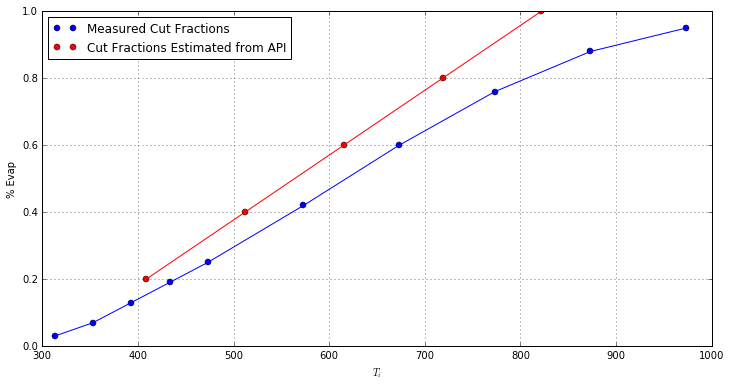

In [165]:
plt.figure(1, figsize=(12,6))
plt.subplot(111)

plt.plot(boiling_points, cum_fractions, 'bo', label="Measured Cut Fractions")
plt.plot(boiling_points, cum_fractions, 'b-')
plt.plot(api_boiling_points, api_cum_fractions, 'ro', label="Cut Fractions Estimated from API")
plt.plot(api_boiling_points, api_cum_fractions, 'r-')

plt.xlabel(r'$T_i$')
plt.ylabel('% Evap')
plt.grid()

plt.legend(loc='upper left')


Well, I suppose this estimation is not too far off considering we are choosing constants based on the average of all oils in our database.  It would be interesting to make this comparison for all oils that contain distillation cuts.

### <center>(End JLM Comments) </center>

### Properties of PCs for data conditions 1 & 2:

Each PC generated through the above data conditions is split into two sub-components, which are themselves PCs representing saturates and aromatics at a given boiling point $(PC_s \text{ and } PC_a)$.  The vapor pressure of each PC is based on Antoine's equation as discussed by Lyman et al.

$$
\begin{align}
P_i &= \text{the PC vapor pressure } (Pa) \cr
P^0 &= \text{atmospheric pressure } (Pa) \cr
BP_i &= \text{the PC boiling point} \cr
C_{2,i} &= 0.19 \cdot BP_i - 18 = \text{???} \cr
\Delta S_i &= 8.75 + 1.987 log(BP_i) = \text{???} \cr
\Delta Z_b &= 0.97 = \text{???} \cr
R_{cal} &= 1.987 = \text{???} \cr
T_{water} &= \text{ambient water temperature} (K) \cr
\cr
ln {P_i \over P^0} &= {\Delta S_i (BP_i - C_{2,i})^2 \over \Delta Z_b R_{cal} BP_i} \left[{1 \over BP_i - C_{2,i}} - {1 \over T_{water} - C_{2,i}} \right] \cr
\end{align}
$$

The effective molecular weight of each pseudo-component is based on correlations for alkanes (saturates) and aromatic compounds.

$$
\begin{align}
mw_i^S &= 0.04132 - (1.985 \cdot 10^{-4} \cdot BP_i) + (9.494 \cdot 10^{-7} \cdot (BP_i)^2) \cr
mw_i^A &= E - (F \cdot BP_i) + (G \cdot (BP_i)^2) \cr
\end{align}
$$

Where the constants E, F, and G are based on a correlation <b><u>to be determined</u></b>.

### <center>(JLM Comments) </center>

Ok, this section does not seem to be very well defined at all, and in fact seems incomplete.  I am not sure I can do anything with this until we can fill in some of the blanks.<br>
However we are currently calculating the molecular weights in the oil library based on the following equations based on Bills oil property estimation document:

$$
\begin{align}
mw_i^S &= 49.7 \cdot (6.983 - ln(1070 - BP_i))^{3/2} \cr
mw_i^A &= 44.5 \cdot (6.91 - ln(1015 - BP_i))^{3/2} \cr
\end{align}
$$

### <center>(End JLM Comments) </center>

## <u>Calculating Evaporation</u>

Evaporation of saturate and aromatic PCs is found from the solution of coupled simple differential equations:

$$
\begin{align}
f_w &= \text{the fractional water content in the emulsion} \cr
V_{LE} &= \text{the volume of the LE???} \cr
K_i &= \text{the PC mass transport coefficient} (m / s) \cr
m_i &= \text{the PC mass} (kg) \cr
mw_i &= \text{the PC molecular weight} (kg / mole) \cr
P_i &= \text{the PC vapor pressure} (Pa) \cr
\zeta &= \text{the thickness of the LE???} \cr
R &= \text{gas constant} = 8.3144 J/K, mole \cr
T_{water} &= \text{ambient water temperature} (K) \cr
\cr
{dm_i \over dt} &= -(1 - f_w) {V_{LE} K_i mw_i P_i \over \zeta RT_{water}} \left[{m_i / mw_i \over \sum{m_i / mw_i}}\right] \cr
\end{align}
$$

The form of the mass transport coefficient is now defined by Bill.  Earlier I thought it could be proportional to a power series in wind speed based on the work of Wanninkhof, but no longer feel confident in that.<br>
I think the form can be expressed as an undefined function of wind speed (Bill has proposed a functional dependence).

$$
\begin{align}
\beta &= 0.0048 = \text{a constant} \cr
Sc_i &= \text{the PC Schmidt number (0.6 for water)} \cr
D &= \text{the along-wind pool diameter (set to 1m)} \cr
U &= \text{wind speed at 10 meters (m/sec)} \cr
\cr
K_i &= \beta \cdot Sc_i^{-2/3} \cdot D^{-1/9} \cdot f(U) \cr
\end{align}
$$

The Schmidt number can be estimated from the molecular weight and the Schmidt number for water is found by:

$$
\begin{align}
Sc_i = 0.6 \cdot \root \of {mw_i \over mw_{water}} \cr
\end{align}
$$

Output:<br>
A CSV file with (mass / sum(mass))s, and mass fraction evaporated for every hour of spill.

Notation:<br>
<i>The following notation is used in this summary:</i>

$$
\begin{align}
A &= \text{surface area of the spill} (m^2) \cr
BP_i &= \text{the boiling point of the } i_{th} \text{ pseudo component} (K) \cr
f_i &= \text{the cumulative mass fraction of oil distilled} \cr
K_i &= \text{the reference mass transport coefficient} (m / s) \cr
m_i &= \text{the mass component i in the slick} (kg) \cr
mw_i &= \text{the molecular weight of component i} (kg / mole) \cr
P &= \text{the vapor pressure of the oil as a function of time} (Pa) \cr
P_i &= \text{the vapor pressure of pseudo component i} (Pa) \cr
P_0 &= \text{atmospheric pressure} (Pa) \cr
R &= \text{gas constant} = 8.3144 J/K, mole \cr
T_{water} &= \text{ambient water temperature} (K) \cr
T_i &= \text{measured temperature of distillate} (K) \cr
t &= \text{time since release} (s) \cr
U &= \text{wind speed at 10m elevation above slick} (m / s) \cr
\end{align}
$$

### Notes

Some constants need to be evaluated yet.<br>
Payne used the density of the cuts to refine the correlations for vapor pressure and molecular weight (referring back to a 109944 publication by Gamson and Watson).  Since we don't anticipate having density of cuts, it is not useful.

A suggested further study would be to examine the effects of Fickian diffusion within the oil phase.  To diffuse or not to diffuse.

Pros:<br>
<ul>
    <li>Low hanging fruit: well defined problem, level of effort is moderate and can be assessed.</li>
    <li>Bragging rights included.</li>
    <li>It's fun.</li>
</ul>
Cons:<br>
<ul>
    <li>Best theory reproduces and predicts observations.  No observations=very simple theory.  There is no need.</li>
    <li>No one is complaining.</li>
    <li>We are state of the art right now.</li>
</ul>
Unknowns:<br>
<ul>
    <li>Does it fit in the schedule? (TBD)</li>
</ul>


My feeling is that there are lots of things broken in Adios, and things that could be improved in the way we do weathering.  Some might be too difficult to take on, others are worth taking a whack at, or at least learning enough to know whether they are tractable problems:
<ul>
    <li>Photo-oxidation</li>
    <li>Database design, diesels, standard oils</li>
    <li>Observational methods for emulsions</li>
</ul>


Bill sent me one of Merv's manuscripts with some references.  There are a couple other papers that Merv references that might shed some light on the problem of evaporation: references 28 and 29 deal with photo-oxidation.  Fig. 14 shows evaporation of stirred and non-stirred oil where the oil visibly skinned over.  Not an enormous difference but I don't know the thickness without digging up references, and even then might not know because it was just an AMOP presentation.

Evaporation at sea might be quite complicated.  The level of acceptable uncertainty has not been established so we have no design criteria.<br>
Operationally, our very simple models seem to be just fine.  The stirred vs. non-stirred experiments might give us some insight into how far off we might be, but it is not definitive.

<u>July 9, 2014</u><br>
Evan Variano from Berkeley talked to us about the effects of waves and sea spray on evaporation.  He suggested that the mass transfer coefficient is proportional to the square of the wind speed and left some papers.

Ho's paper "assumes" quadratic wind speed dependence.  And the lowest wind speed measured was 7 m/s.<br>
The review by Wanninkhof is more interesting.  He says the data fit a 3rd order polynomial, and suggests that there is a positive intercept, but below 8 m/s the cubic term is insignificant.

I'm thinking the best way to do this is to have the mass transfer coefficient proportional to $a + bU +cU^2$.  That leaves 3 parameters to find if we buy the non-zero intercept argument.

Mackay and Matsugu (1973) is where we got our formula for mass transfer coefficient for Adios2.  The exponent was based on earlier literature, and they did not specify the wind speed since it occurred over several days on the roof of their building.

I guess Brighton is the next place to look.